In [121]:
# Import necessary libraries
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [68]:
# Load the dataset
df = pd.read_excel('data/processed/data_men_women.xlsx')
df = df[~df['Rank_Worldwide'].isna()]  # Filter out rows with missing 'Rank_Worldwide'
print(f"Rank range: {int(df['Rank_Worldwide'].min())}-{int(df['Rank_Worldwide'].max()):,}")

Rank range: 1-164,758


This large rank range would create a very large classification task. Instead of trying to predict individual rankings, I will try to predict the rank range that an athlete falls into.

First, I explore the distribution of samples by rank range to try to split the ranges into equal categories.

Bin edges: [     1.   3447.   9536.  21506.  34240.  54396. 164758.]
Support for Each Bin:
Rank_Category
1-3447          1397
3448-9536       1397
9537-21506      1398
21507-34240     1397
34241-54396     1396
54397-164758    1398
Name: count, dtype: int64


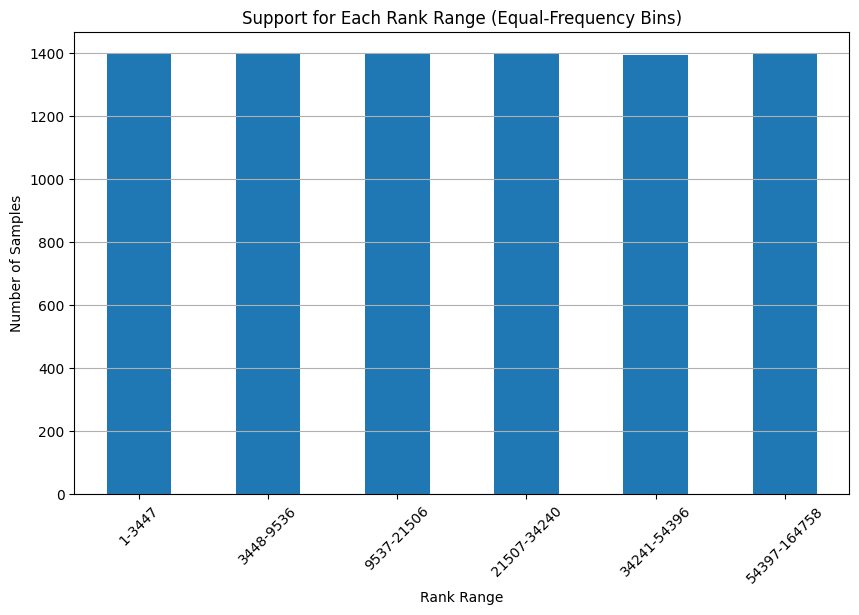

In [69]:
# Create equal-frequency bins (quantiles) and save the bin edges
df['Rank_Category'], bin_edges = pd.qcut(df['Rank_Worldwide'], q=6, labels=["1-3447", "3448-9536", "9537-21506", "21507-34240", "34241-54396", "54397-164758"], retbins=True)

# Print the bin edges
np.set_printoptions(suppress=True)
print("Bin edges:", bin_edges)

# Check the support for each bin after creating the Rank_Category
bin_counts = df['Rank_Category'].value_counts().sort_index()

# Print the counts for each bin
print("Support for Each Bin:")
print(bin_counts)

# Plot
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar')
plt.title('Support for Each Rank Range (Equal-Frequency Bins)')
plt.xlabel('Rank Range')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Based on the results above, I define the bins as shown below.

In [70]:
# Define bin edges and labels for the target variables of worldwide ranking
bins = [0, 3500, 10000, 20000, 35000, 50000, 164758]
labels = ["Top 2%", "2-6%", "6-12%", "12-21%", "21-30%", "30%+"]

df['Rank_Category'] = pd.cut(df['Rank_Worldwide'], bins=bins, labels=labels, right=True)

In [71]:
# Define features and target
features = ['Back Squat (lbs)', 'Clean and Jerk (lbs)', 'Deadlift (lbs)',
            'Snatch (lbs)', 'Fight Gone Bad', 'Max Pull-ups', 'Chad1000x (s)',
            'L1 Benchmark (s)', 'Filthy 50 (s)', 'Fran (s)', 'Grace (s)',
            'Helen (s)', 'Run 5k (s)', 'Sprint 400m (s)']
target = "Rank_Category"

In [72]:
# Split data into men and women
men_df = df[df['Division'] == "Men"]
women_df = df[df['Division'] == "Women"]

men_X = men_df[features]
men_y = men_df[target]

women_X = women_df[features]
women_y = women_df[target]

In [73]:
# Impute missing values with the mean
imp = SimpleImputer(strategy='mean')
men_X = imp.fit_transform(men_X)
women_X = imp.fit_transform(women_X)

# Standardize the data
scaler = StandardScaler()
men_X = scaler.fit_transform(men_X)
women_X = scaler.fit_transform(women_X)

In [74]:
# Split into train and test sets
# I use stratify to ensure that each class (rank range) in the target variable is represented 
# in the same proportion in the training and testing sets.
men_X_train, men_X_test, men_y_train, men_y_test = train_test_split(
    men_X, men_y, test_size=0.2, random_state=42, stratify=men_y
)
women_X_train, women_X_test, women_y_train, women_y_test = train_test_split(
    women_X, women_y, test_size=0.2, random_state=42, stratify=women_y)

In [75]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(f'Confusion Matrix for {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [76]:
# Hyperparameter tuning function
def tune_model(X_train, y_train, param_grid):
     # Initialize the model
    rf_classifier = RandomForestClassifier(random_state=42)

    # Hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Return the best model
    return grid_search.best_estimator_

# Hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100], # Number of trees in the forest
    'max_depth': [10, 20], # Max depth of the trees
    'min_samples_split': [2, 5], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2] # Minimum number of samples required to be at a leaf node
}

Considerations for hyperparameter tuning:
- **n_estimators**: Increasing the number of trees in the forest may improve model performance and generalizability, but increases runtime with potentially diminishing returns
- **max_depth**: Limiting tree depth helps avoid overfitting, which is why <i>None</i> was initially not included.
- **min_samples_split**: 2 gives maximum splitting (deeper trees) while 5 restricts some splitting (less complex trees). Less complex trees can help reduce overfitting.
- **min_samples_leaf**: 1 means leaves can have only one single sample. 2 forces leaves to have at least two samples, helping to regularize the model and prevent overfitting. Setting min_samples_leaf to 2 can help ensure the model learns from general patterns rather than overfitting single samples to unique rankings. 

In [77]:
# Model evaluation function
def evaluate_model(model, X_test, y_test, title):
    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{title} Accuracy: {accuracy:.4f}")
    print(f"Classification Report for {title}:\n", classification_report(y_test, y_pred))

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, title)


### Random Forest Model - Version 1

Men's Division Accuracy: 0.3571
Classification Report for Men's Division:
               precision    recall  f1-score   support

      12-21%       0.25      0.34      0.29       211
        2-6%       0.24      0.22      0.23       195
      21-30%       0.27      0.04      0.08       160
        30%+       0.52      0.73      0.61       251
       6-12%       0.22      0.09      0.12       148
      Top 2%       0.37      0.52      0.43       172

    accuracy                           0.36      1137
   macro avg       0.31      0.32      0.29      1137
weighted avg       0.33      0.36      0.32      1137



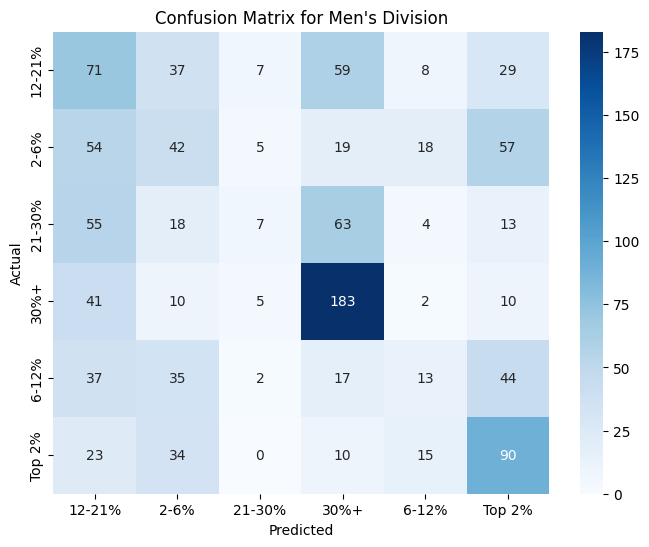

In [78]:
best_men_rf_model = tune_model(men_X_train, men_y_train, param_grid)
evaluate_model(best_men_rf_model, men_X_test, men_y_test, "Men's Division")

Women's Division Accuracy: 0.3623
Classification Report for Women's Division:
               precision    recall  f1-score   support

      12-21%       0.32      0.62      0.42       117
        2-6%       0.11      0.03      0.05        92
      21-30%       0.24      0.07      0.11        59
        30%+       0.55      0.39      0.45        75
       6-12%       0.30      0.15      0.20        86
      Top 2%       0.43      0.67      0.52       112

    accuracy                           0.36       541
   macro avg       0.32      0.32      0.29       541
weighted avg       0.32      0.36      0.31       541



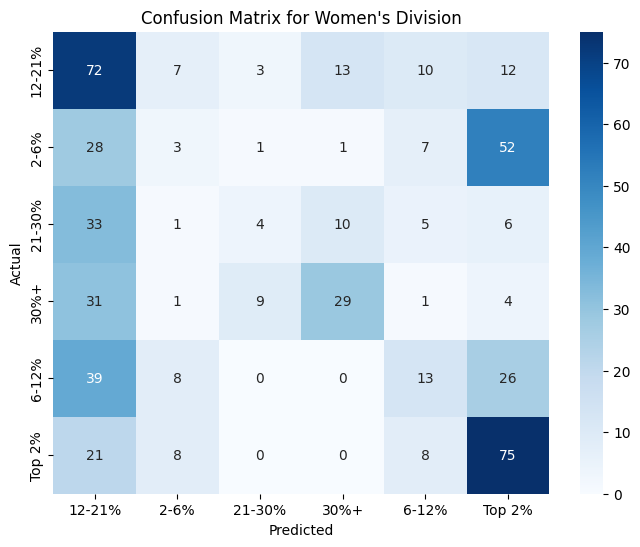

In [79]:
best_women_rf_model = tune_model(women_X_train, women_y_train, param_grid)
evaluate_model(best_women_rf_model, women_X_test, women_y_test, "Women's Division")

### Interpretation of Evaluation Metrics:
- The accuracy of the Men's Division model is 37%, indicating the model correctly predicted the rank range only about one-third of the samples. The accuracy of the Women's Division model is slightly worse at 36%.
- The precision for both men and women categories is low, meaning that of the predicted positive instances, only few of them were actual positives. 
- Recall (or sensitivity) measures how many of the actual positive instances were predicted to be positive. 
    - For the Men's division, 74% of athletes who are actually in the "30+" rank category were predicted to be in that range. However, the "6-12%" category had only a 5% recall, meaning only 5% of athletes in this in the 6-12% range were predicted to be in that category.
    - The Women's division had a high recall for the "30+" category at 56%, while the "21-30%" category had a low recall at 5%. The model failed to recognize 95% of instances in the 21-30% women's category.
- The F1 Score is the harmonic mean between precision and recall. Both the men and women divisions have low F1 scores, meaning the models are having a hard time distinguishing between rank ranges and not balance precision and recall well.

### Random Forest Model - Version 2

Given the low performance of the models, I adjust the hyperparameters to see if it results in a better model.
- Increased the number of trees 
- Did not restrict the depth of the trees

In [87]:
param_grid = {
    'n_estimators': [1000, 5000], # Number of trees in the forest
    'max_depth': [None, 10, 20], # Max depth of the trees
    'min_samples_split': [2, 5], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2] # Minimum number of samples required to be at a leaf node
}

Men's Division Accuracy: 0.3712
Classification Report for Men's Division:
               precision    recall  f1-score   support

      12-21%       0.25      0.36      0.30       211
        2-6%       0.27      0.25      0.26       195
      21-30%       0.35      0.04      0.08       160
        30%+       0.52      0.73      0.61       251
       6-12%       0.30      0.11      0.16       148
      Top 2%       0.38      0.53      0.45       172

    accuracy                           0.37      1137
   macro avg       0.35      0.34      0.31      1137
weighted avg       0.36      0.37      0.33      1137



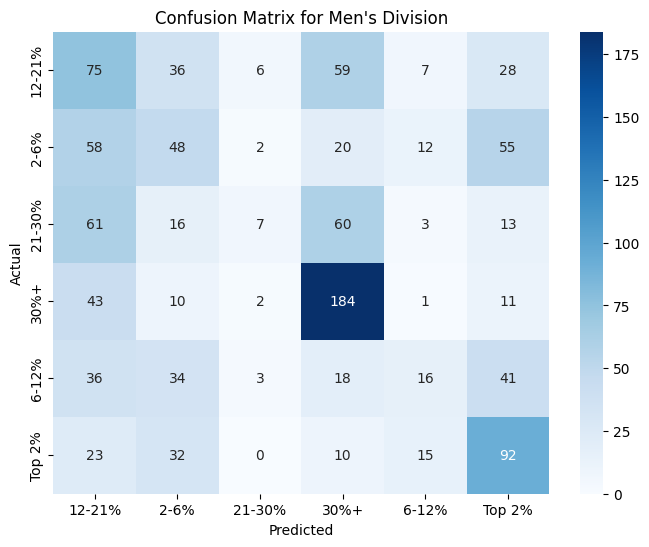

Women's Division Accuracy: 0.3697
Classification Report for Women's Division:
               precision    recall  f1-score   support

      12-21%       0.32      0.62      0.43       117
        2-6%       0.13      0.03      0.05        92
      21-30%       0.18      0.03      0.06        59
        30%+       0.56      0.43      0.48        75
       6-12%       0.27      0.14      0.18        86
      Top 2%       0.44      0.70      0.54       112

    accuracy                           0.37       541
   macro avg       0.32      0.33      0.29       541
weighted avg       0.32      0.37      0.31       541



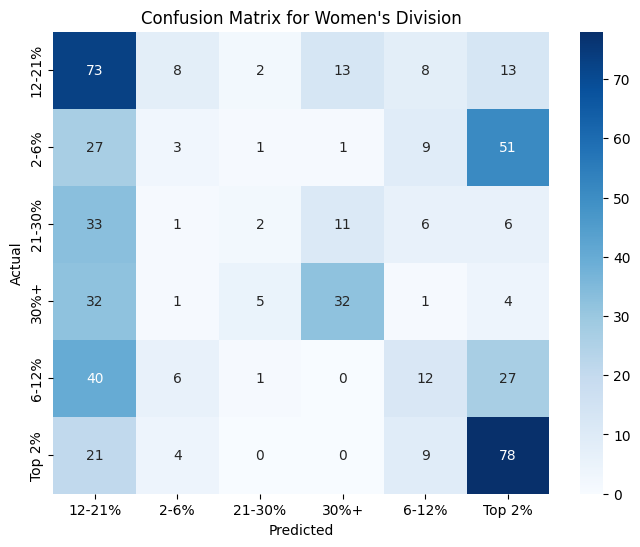

In [88]:
best_men_rf_model = tune_model(men_X_train, men_y_train, param_grid)
evaluate_model(best_men_rf_model, men_X_test, men_y_test, "Men's Division")

best_women_rf_model = tune_model(women_X_train, women_y_train, param_grid)
evaluate_model(best_women_rf_model, women_X_test, women_y_test, "Women's Division")

Increasing the number of trees and the max depth of the trees did not materially improve model performance. 

Because the model did not improve, I visualize the relationship between the features and target to see if they appear to be linear or non-linear. If they are non-linear, interactions between the features could be added to try to help improve model performance.

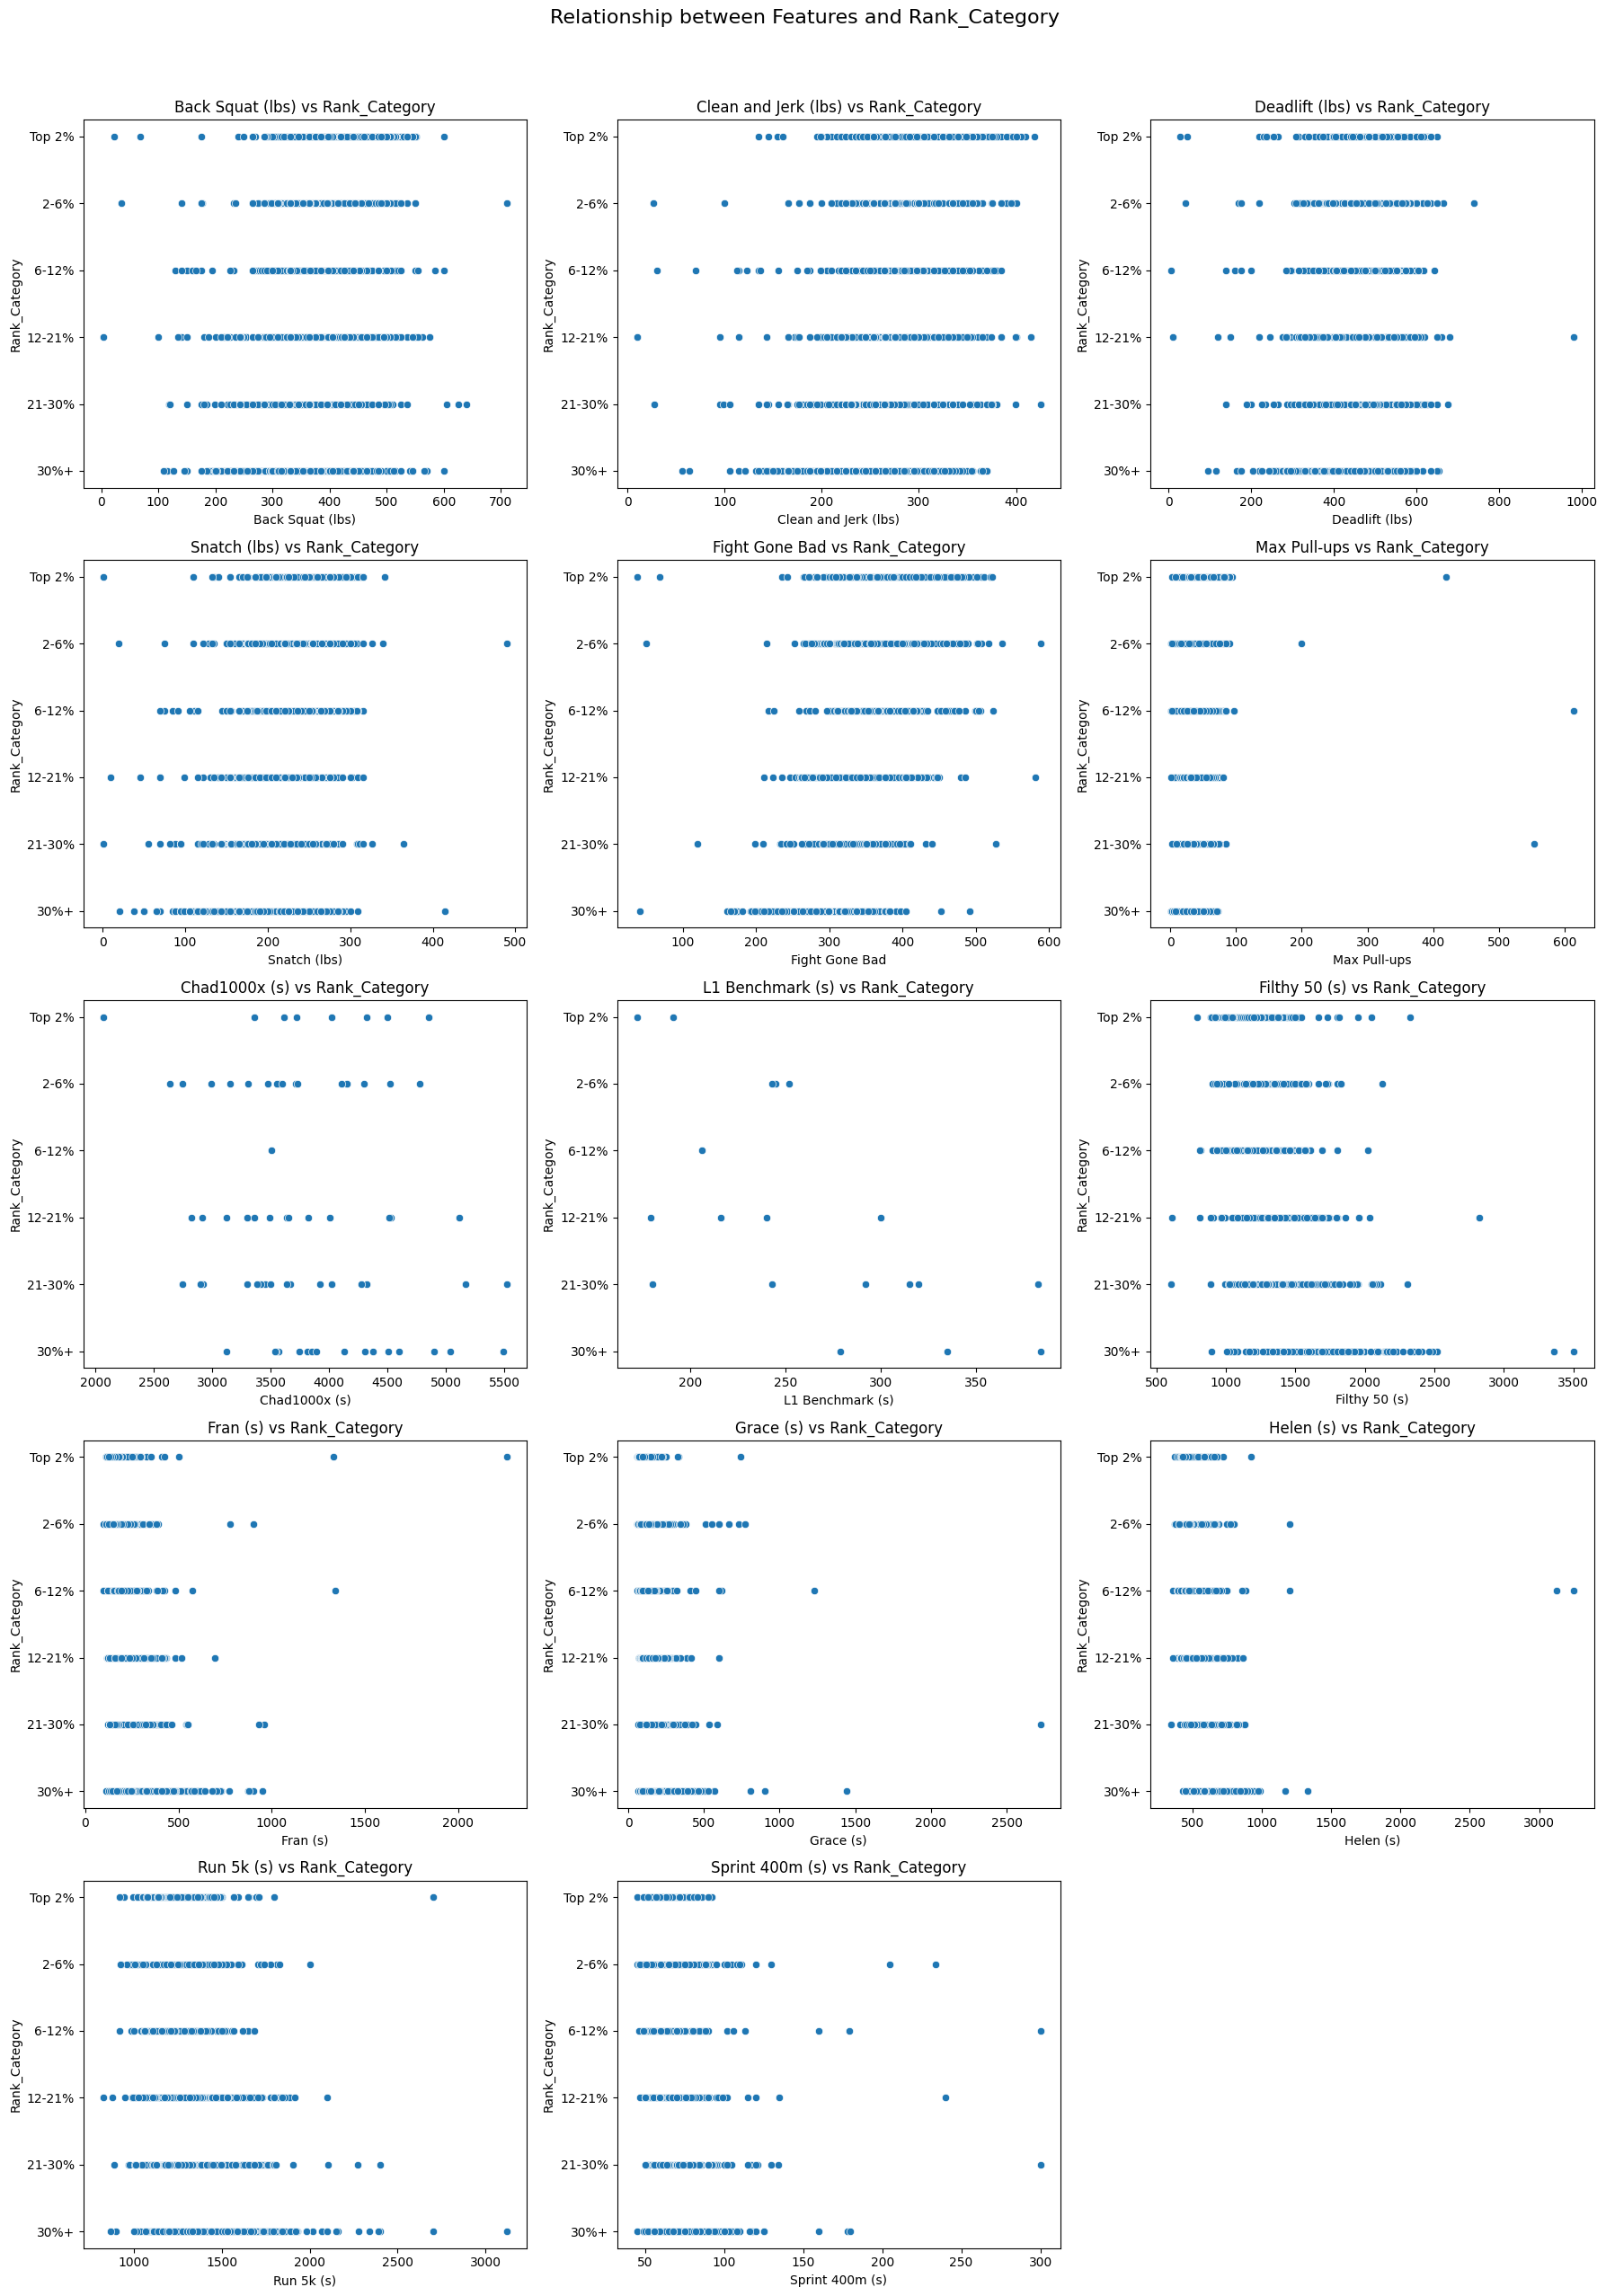

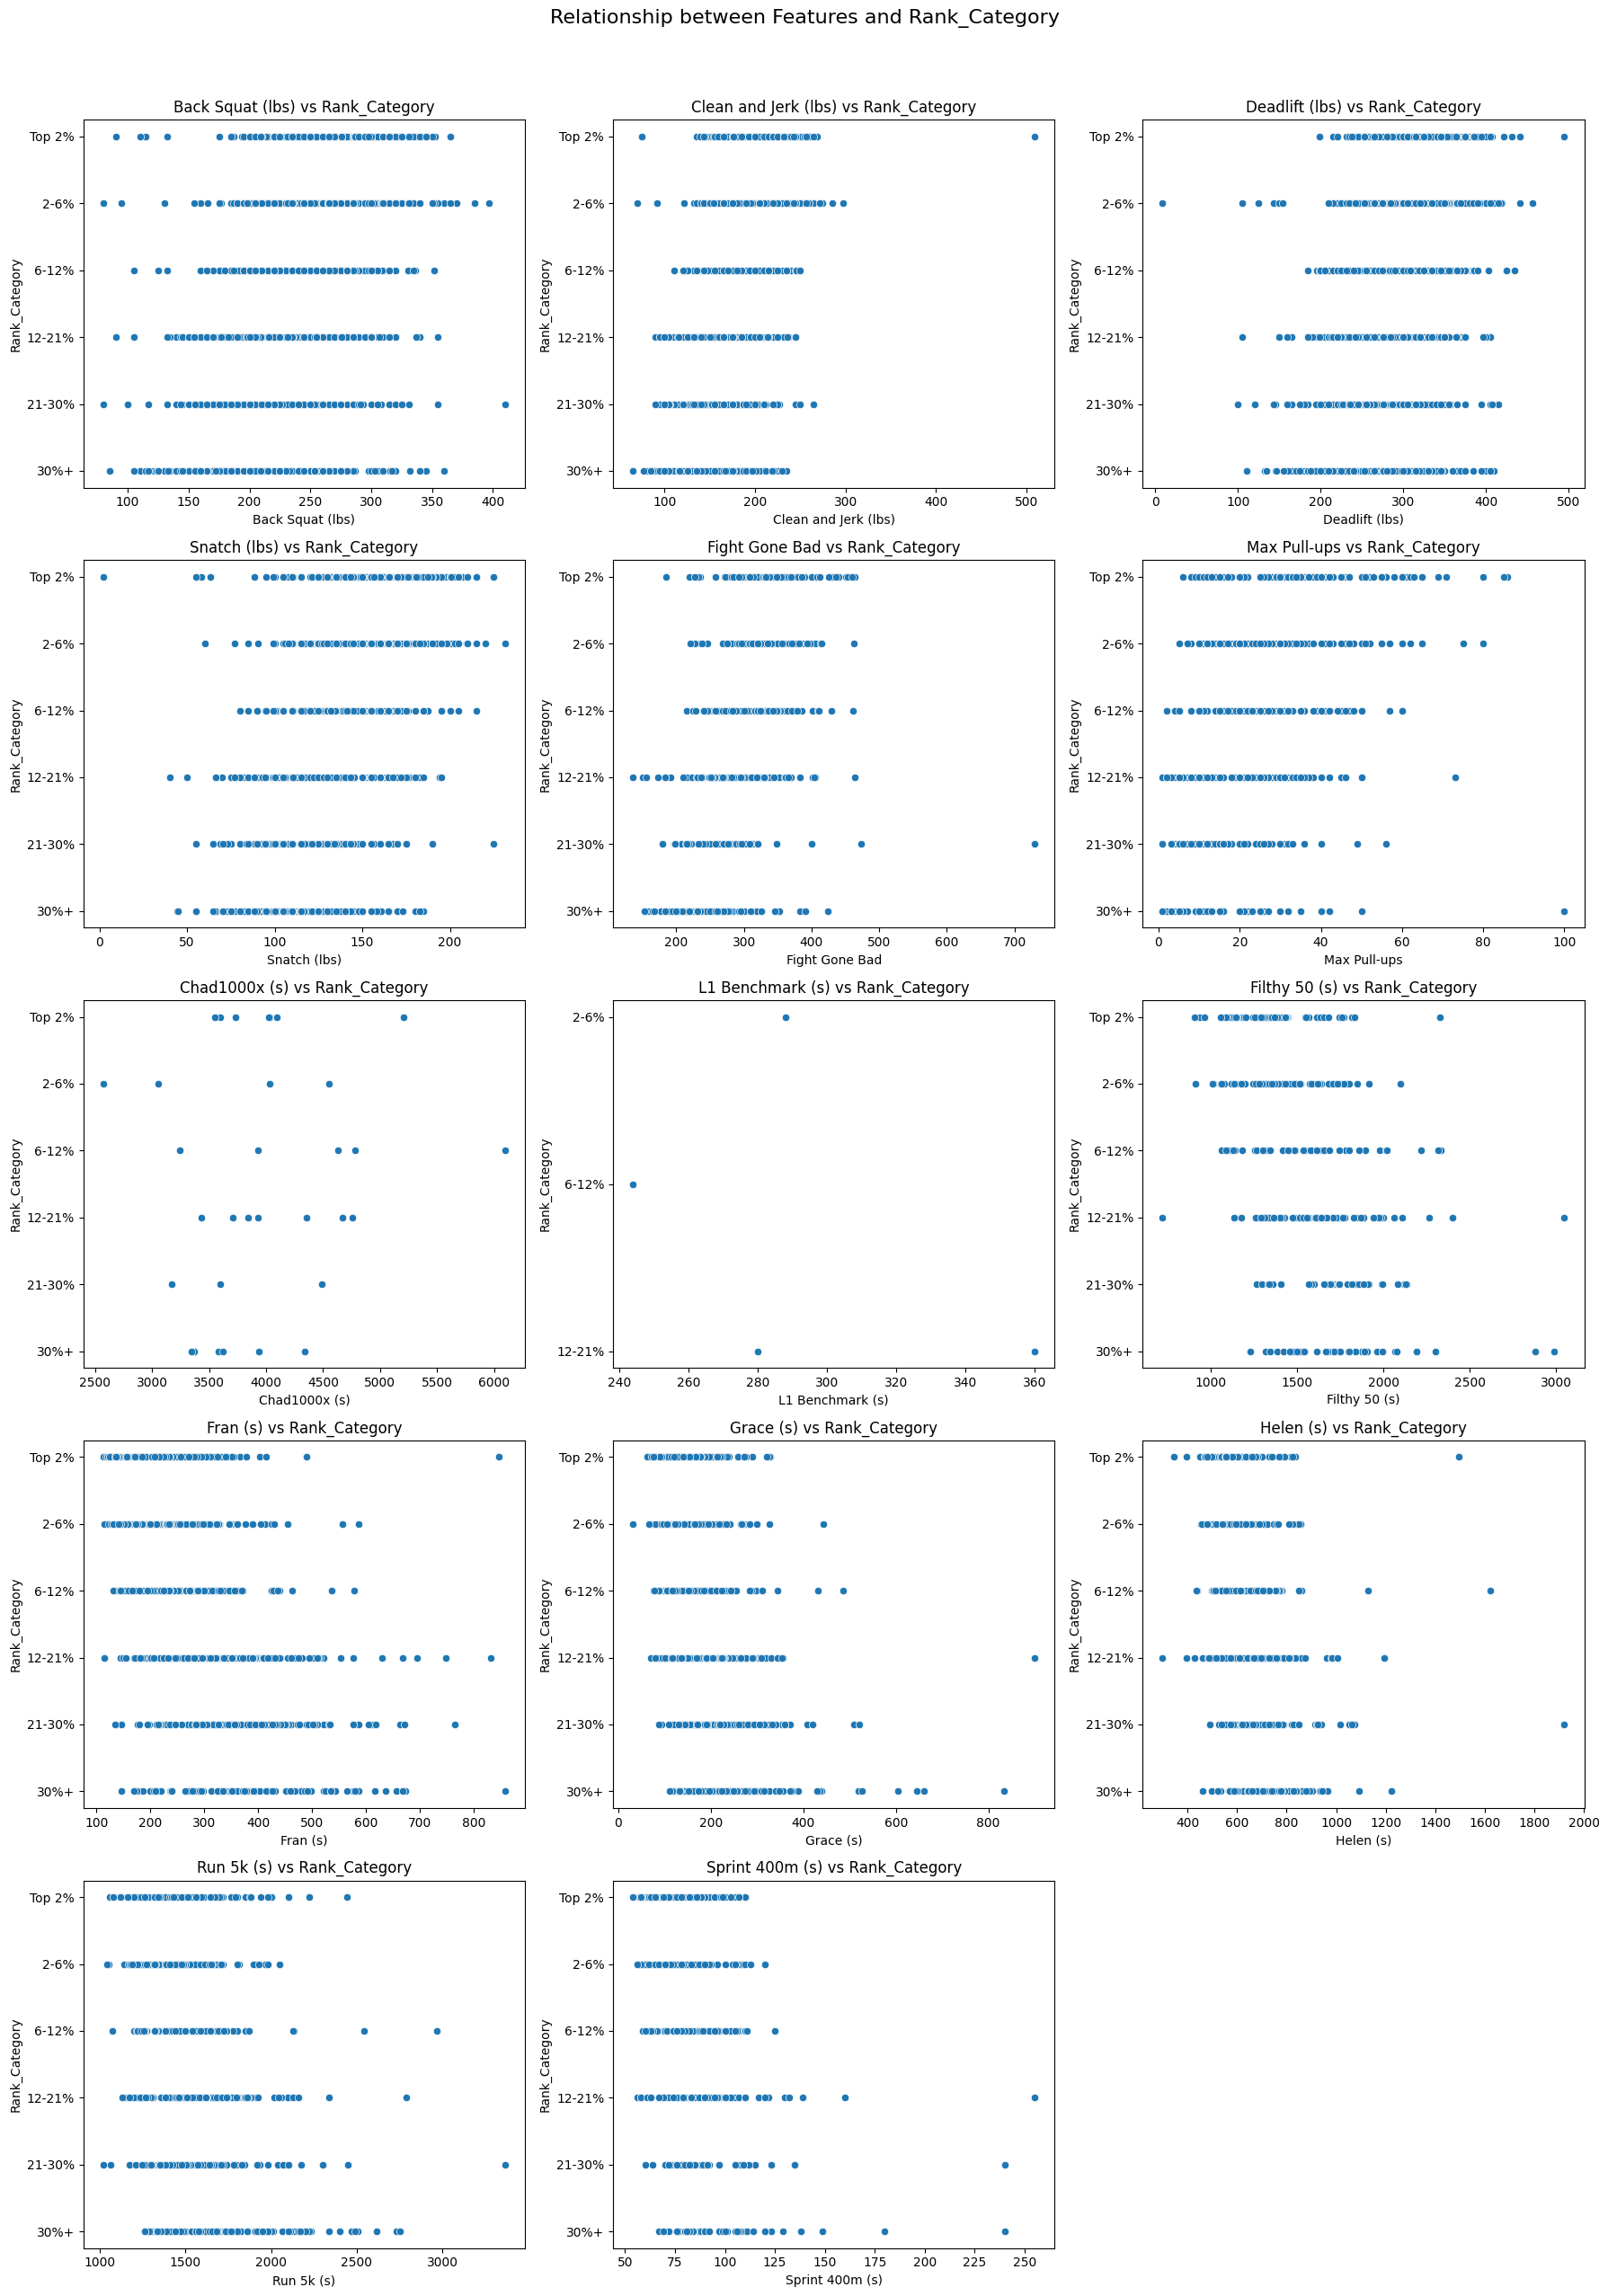

In [103]:
# Function to create scatterplots of features against target (rank category)
def visualize_relationships_scatter_plot(df, features, target):
    num_features = len(features)
    rows = 5

    fig, axs = plt.subplots(rows, 3, figsize=(18, 5 * rows))  
    fig.suptitle(f'Relationship between Features and {target}', fontsize=16, y=1.02)
    
    axs = axs.flatten()  
    
    for i, feature in enumerate(features):
        sns.scatterplot(x=df[feature], y=df[target], ax=axs[i])
        axs[i].set_title(f'{feature} vs {target}')
    
    # Hide any remaining empty subplots since the number of features is not a multiple of 3 (number of rows)
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()


visualize_relationships_scatter_plot(men_df, features, target)
visualize_relationships_scatter_plot(women_df, features, target)

There are no distinct clusters in the scatter plots, meaning the features (benchmark workouts) may not be informative enough to differentiate between rankings. In other words, the benchmark workouts are not predictive of performance in the CrossFit games.

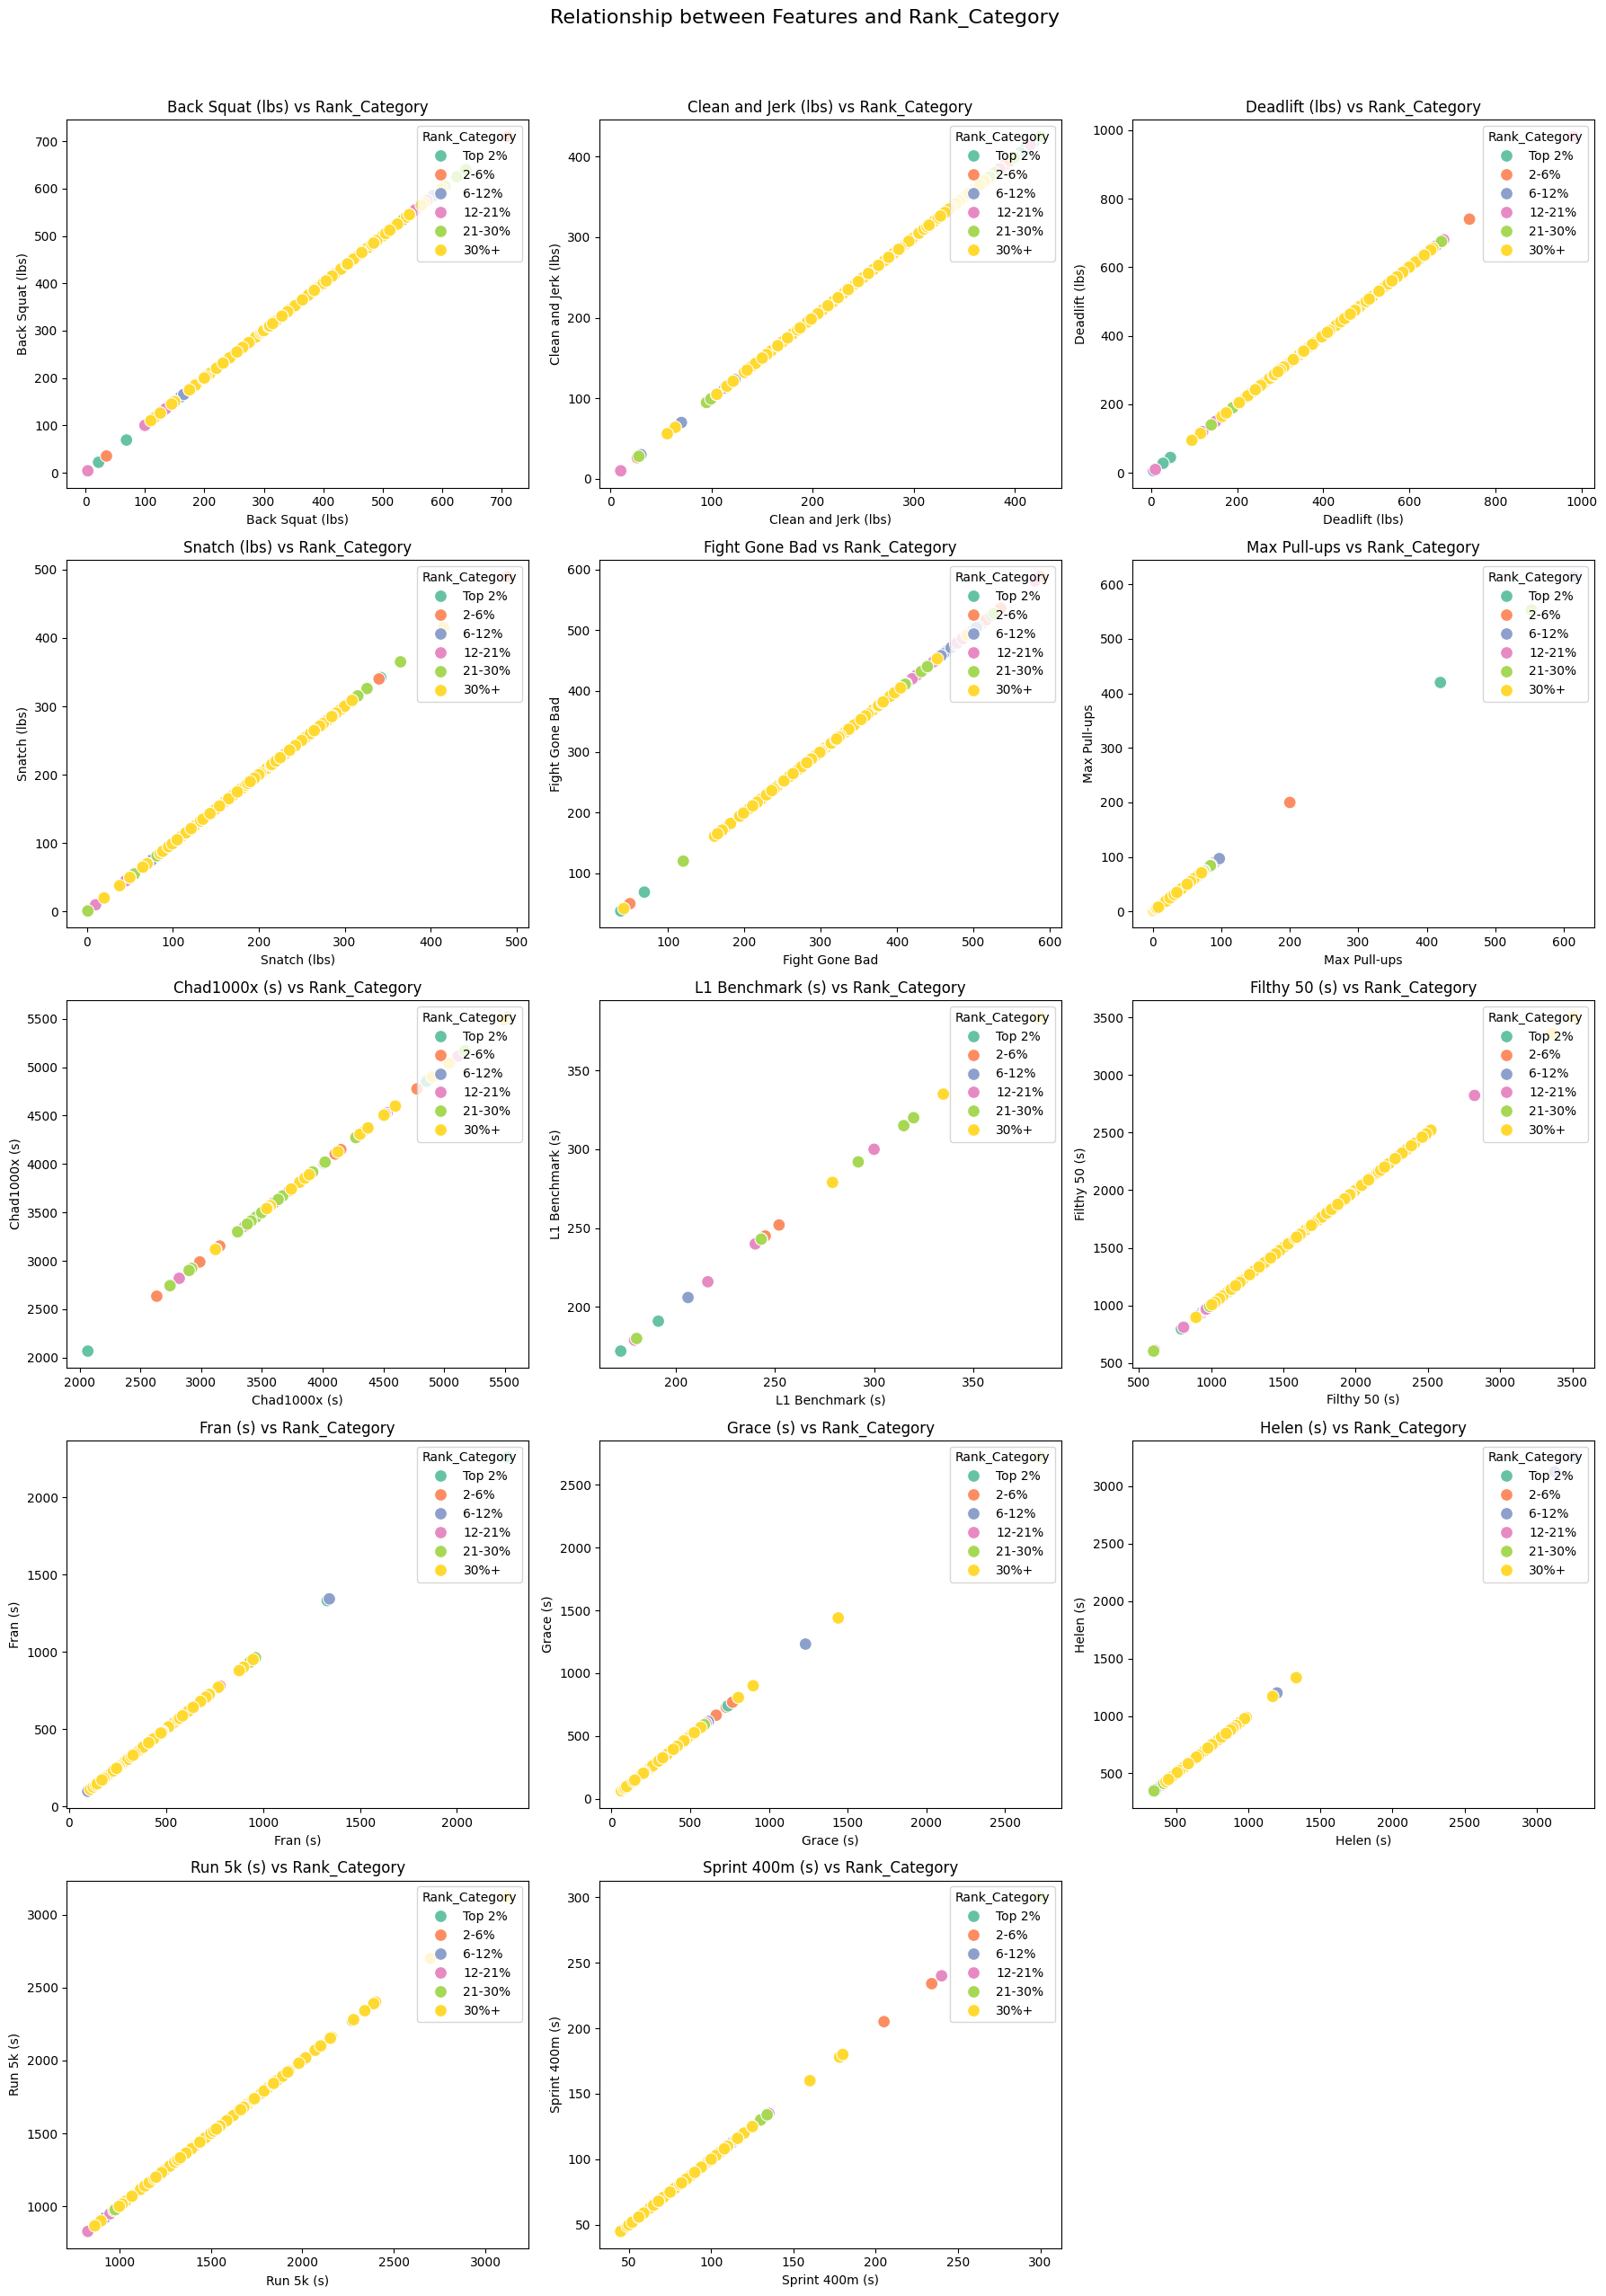

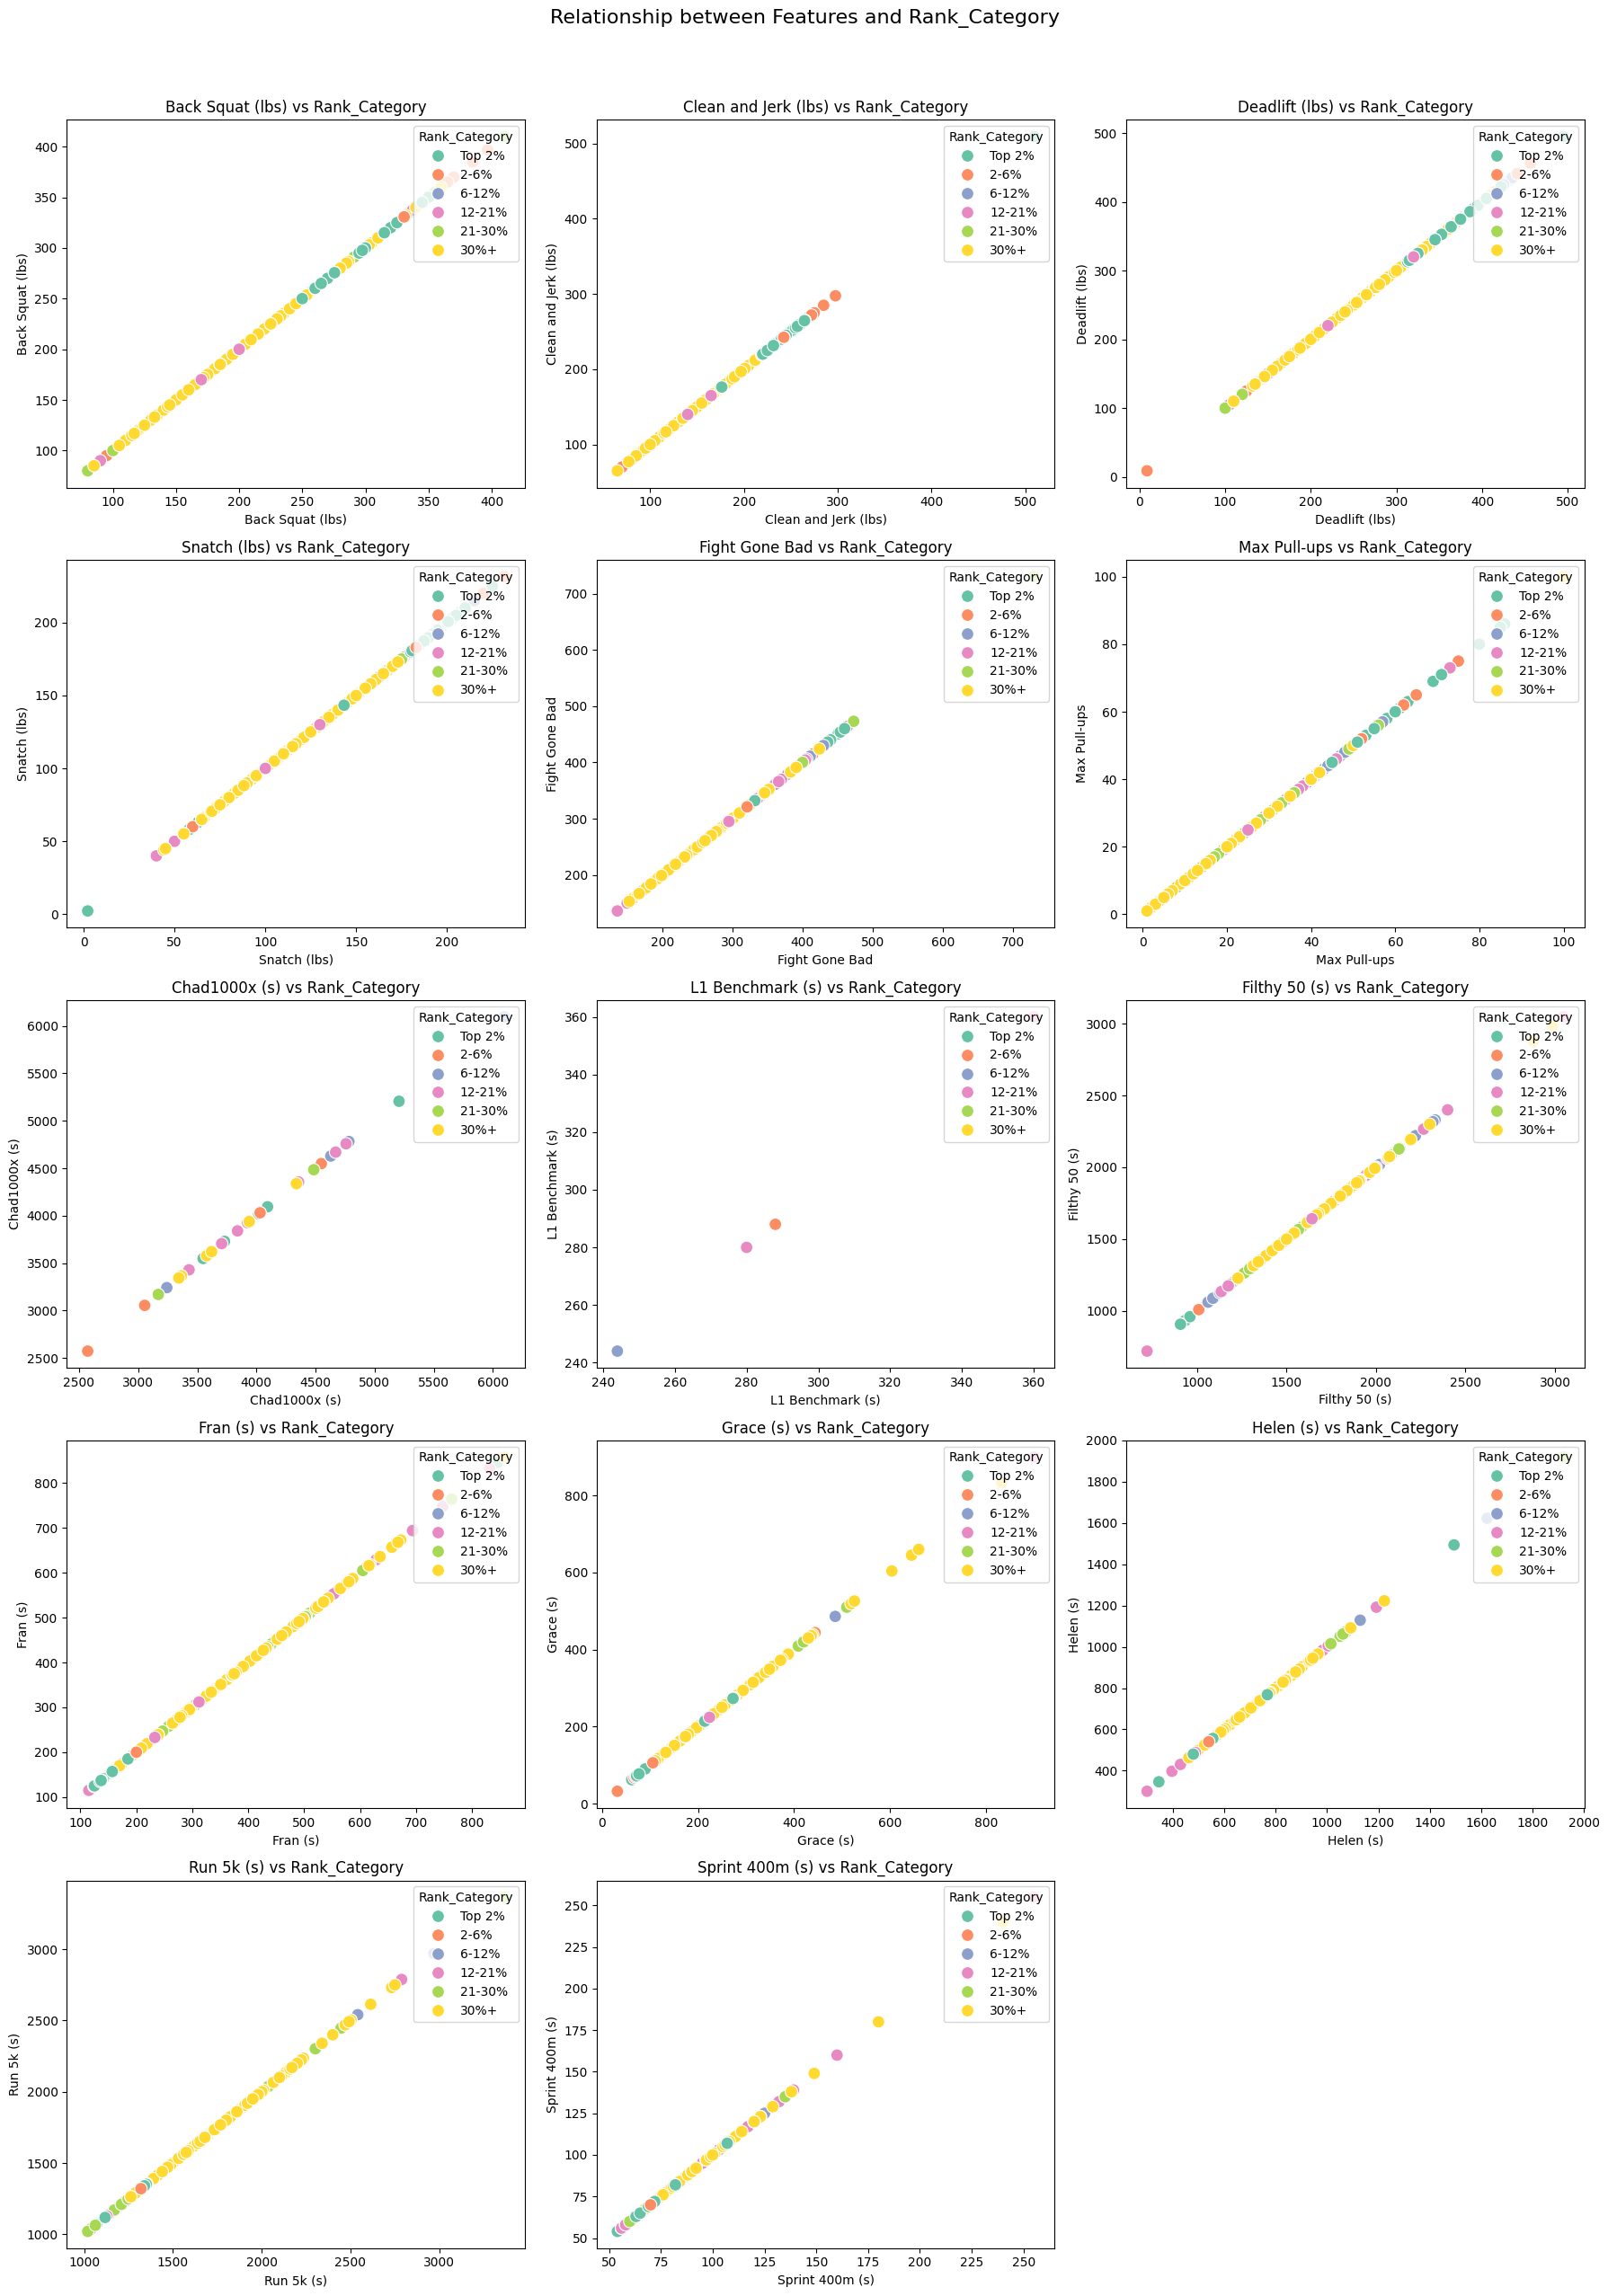

In [106]:
# Function to visualize the distribution of the target variable within the feature space
def visualize_relationships_feature_space(df, features, target):
    num_features = len(features)
    rows = 5

    fig, axs = plt.subplots(rows, 3, figsize=(18, 5 * rows))  
    fig.suptitle(f'Relationship between Features and {target}', fontsize=16, y=1.02)
    
    axs = axs.flatten()  
    
    for i, feature in enumerate(features):
        sns.scatterplot(x=df[feature], y=df[feature], hue=df[target], ax=axs[i], palette='Set2', s=100)
        axs[i].set_title(f'{feature} vs {target}')
        axs[i].legend(loc='upper right', title=target)
    
    # Hide any remaining empty subplots since the number of features is not a multiple of 3 (number of rows)
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()


visualize_relationships_feature_space(men_df, features, target)
visualize_relationships_feature_space(women_df, features, target)

The target classes (rank categories) overlap within many of the feature spaces; the features don't have clear boundaries that cleanly separate the rank ranges. The results of the athletes' benchmark workouts are so similar that it is difficult for the model to use that information to distinguish which rank range the athlete should fall into. 

### Feature Engineering - Binning Features into Categorical Variables

I bin each of the features into discrete intervals to see turning them into categorical features can help the model capture any subtle non-linear patterns. 

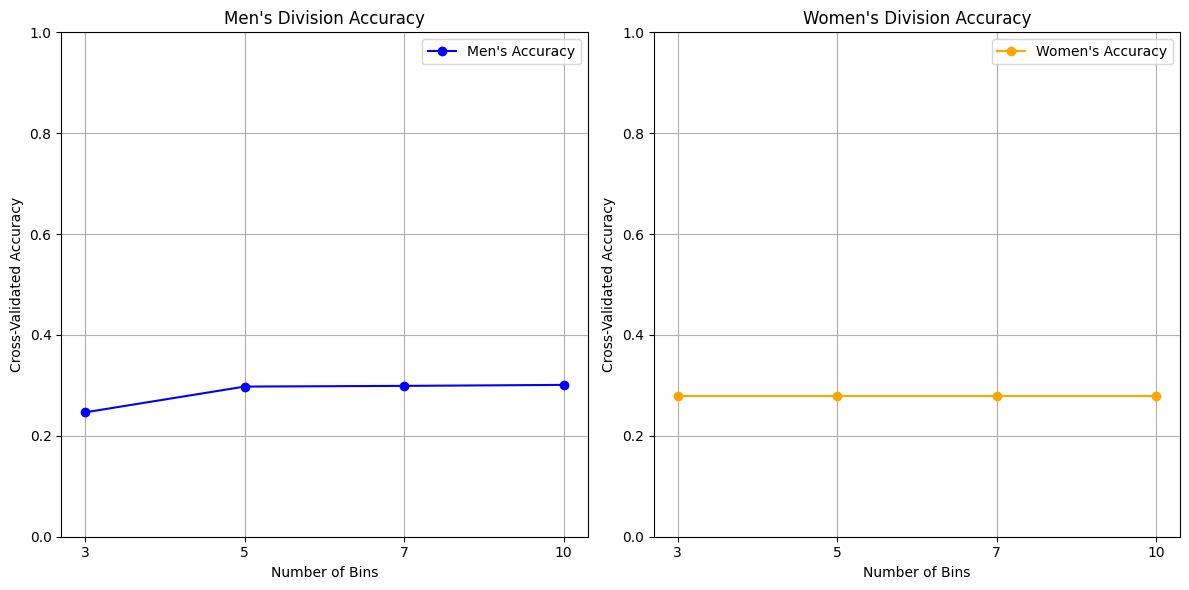

In [127]:
# Binning function
def bin_features(df, num_bins):
    df_binned = pd.DataFrame()
    for feature in features:
        df_binned[feature] = pd.cut(df[feature], bins=num_bins, labels=False)
    df_binned['Rank_Category'] = df['Rank_Category']
    df_binned['Division'] = df['Division']
    return df_binned

# Cross-validation for different bin configurations
bin_counts = [3, 5, 7, 10]  
men_results = {}
women_results = {}

for num_bins in bin_counts:
    df_binned = bin_features(df, num_bins)

    # Split data into men and women
    men_df = df_binned[df_binned['Division'] == "Men"]
    women_df = df_binned[df_binned['Division'] == "Women"]

    men_X = men_df[features]
    men_y = men_df[target]

    # Impute missing values with the mean
    imp = SimpleImputer(strategy='mean')
    men_X = imp.fit_transform(men_X)
    women_X = imp.fit_transform(women_X)

    # Standardize the data
    scaler = StandardScaler()
    men_X = scaler.fit_transform(men_X)
    women_X = scaler.fit_transform(women_X)

    # Define a random forest classifier
    rf_classifier = RandomForestClassifier(random_state=42)

    # Perform cross-validation
    cv_scores_men = cross_val_score(rf_classifier, men_X, men_y, cv=5, scoring='accuracy')
    men_results[num_bins] = cv_scores_men.mean()
    cv_scores_women = cross_val_score(rf_classifier, women_X, women_y, cv=5, scoring='accuracy')
    women_results[num_bins] = cv_scores_women.mean()

# Plot the results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot men's results
axes[0].plot(bin_counts_labels, list(men_results.values()), marker='o', color='blue', label="Men's Accuracy")
axes[0].set_title("Men's Division Accuracy")
axes[0].set_xlabel('Number of Bins')
axes[0].set_ylabel('Cross-Validated Accuracy')
axes[0].set_ylim(0, 1) 
axes[0].legend()
axes[0].grid()

# Plot women's results
axes[1].plot(bin_counts_labels, list(women_results.values()), marker='o', color='orange', label="Women's Accuracy")
axes[1].set_title("Women's Division Accuracy")
axes[1].set_xlabel('Number of Bins')
axes[1].set_ylabel('Cross-Validated Accuracy')
axes[1].set_ylim(0, 1) 
axes[1].legend()
axes[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

The ideal number of bins appears to be 5; increasing it does not improve model accuracy. 

In [113]:
# Number of bins
num_bins = 5

# Create a new DataFrame with binned features
df_binned = pd.DataFrame()

# Apply binning to each feature
for feature in features:
    df_binned[feature] = pd.cut(df[feature], bins=num_bins, labels=False)

df_binned['Rank_Category'] = df['Rank_Category']
df_binned['Division'] = df['Division']

df_binned

Back Squat (lbs)  Clean and Jerk (lbs)  Deadlift (lbs)  Snatch (lbs)  \
0                  2.0                   3.0             2.0           2.0   
1                  3.0                   3.0             2.0           2.0   
2                  2.0                   3.0             2.0           2.0   
3                  2.0                   2.0             2.0           2.0   
4                  3.0                   3.0             2.0           2.0   
...                ...                   ...             ...           ...   
8408               2.0                   2.0             1.0           1.0   
8409               1.0                   2.0             1.0           1.0   
8410               2.0                   2.0             1.0           2.0   
8411               2.0                   2.0             2.0           1.0   
8412               1.0                   1.0             1.0           1.0   

      Fight Gone Bad  Max Pull-ups  Chad1000x (s)  L1 Benchmark (s)  \
0                NaN           NaN            NaN               NaN   
1                2.0           0.0            NaN               NaN   
2                2.0           0.0            NaN               NaN   
3                2.0           0.0            NaN               NaN   
4                NaN           NaN            NaN               NaN   
...              ...           ...            ...               ...   
8408             NaN           NaN            NaN               NaN   
8409             NaN           NaN            NaN               NaN   
8410             NaN           NaN            NaN               NaN   
8411             2.0           NaN            NaN               NaN   
8412             NaN           0.0            NaN               NaN   

      Filthy 50 (s)  Fran (s)  Grace (s)  Helen (s)  Run 5k (s)  \
0               NaN       NaN        0.0        NaN         0.0   
1               NaN       0.0        0.0        0.0         0.0   
2               NaN       0.0        0.0        NaN         NaN   
3               1.0       0.0        0.0        NaN         0.0   
4               NaN       0.0        NaN        NaN         NaN   
...             ...       ...        ...        ...         ...   
8408            NaN       NaN        NaN        NaN         NaN   
8409            NaN       NaN        NaN        NaN         NaN   
8410            NaN       NaN        NaN        NaN         NaN   
8411            NaN       0.0        0.0        0.0         0.0   
8412            1.0       0.0        0.0        NaN         NaN   

      Sprint 400m (s) Rank_Category Division  
0                 NaN        Top 2%      Men  
1                 0.0        Top 2%      Men  
2                 NaN        Top 2%      Men  
3                 NaN        Top 2%      Men  
4                 NaN        Top 2%      Men  
...               ...           ...      ...  
8408              NaN        Top 2%    Women  
8409              NaN        Top 2%    Women  
8410              NaN        Top 2%    Women  
8411              0.0          2-6%    Women  
8412              NaN        12-21%    Women  

[8383 rows x 16 columns]

In [114]:
# Split data into men and women
men_df = df_binned[df_binned['Division'] == "Men"]
women_df = df_binned[df_binned['Division'] == "Women"]

men_X = men_df[features]
men_y = men_df[target]

women_X = women_df[features]
women_y = women_df[target]

# Impute missing values with the mean
imp = SimpleImputer(strategy='mean')
men_X = imp.fit_transform(men_X)
women_X = imp.fit_transform(women_X)

# Standardize the data
scaler = StandardScaler()
men_X = scaler.fit_transform(men_X)
women_X = scaler.fit_transform(women_X)

# Split into train and test sets
men_X_train, men_X_test, men_y_train, men_y_test = train_test_split(
    men_X, men_y, test_size=0.2, random_state=42, stratify=men_y
)
women_X_train, women_X_test, women_y_train, women_y_test = train_test_split(
    women_X, women_y, test_size=0.2, random_state=42, stratify=women_y)

Men's Division Accuracy: 0.3298
Classification Report for Men's Division:
               precision    recall  f1-score   support

      12-21%       0.23      0.35      0.28       211
        2-6%       0.22      0.23      0.22       195
      21-30%       0.17      0.02      0.03       160
        30%+       0.49      0.67      0.56       251
       6-12%       0.19      0.03      0.05       148
      Top 2%       0.36      0.48      0.41       172

    accuracy                           0.33      1137
   macro avg       0.28      0.29      0.26      1137
weighted avg       0.29      0.33      0.29      1137



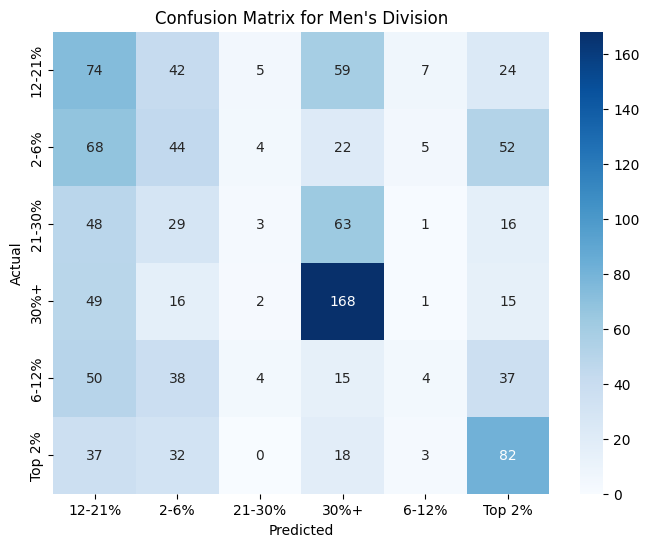

Women's Division Accuracy: 0.3383
Classification Report for Women's Division:
               precision    recall  f1-score   support

      12-21%       0.26      0.80      0.40       117
        2-6%       0.23      0.05      0.09        92
      21-30%       0.67      0.03      0.06        59
        30%+       0.62      0.35      0.44        75
       6-12%       0.25      0.03      0.06        86
      Top 2%       0.50      0.47      0.49       112

    accuracy                           0.34       541
   macro avg       0.42      0.29      0.26       541
weighted avg       0.40      0.34      0.28       541



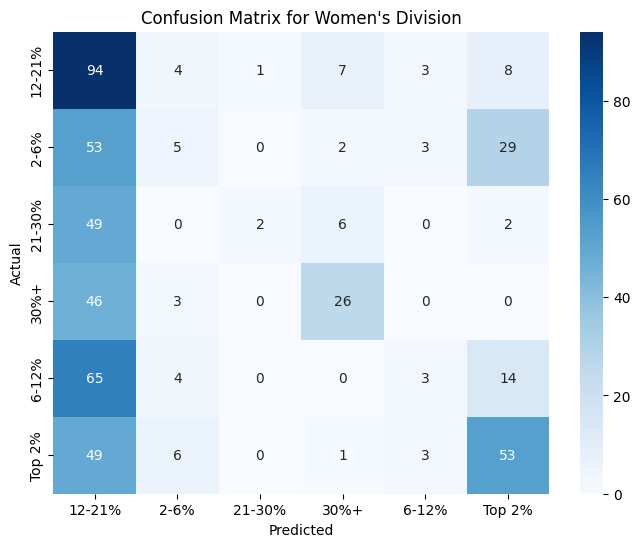

In [115]:
best_men_rf_model = tune_model(men_X_train, men_y_train, param_grid)
evaluate_model(best_men_rf_model, men_X_test, men_y_test, "Men's Division")

best_women_rf_model = tune_model(women_X_train, women_y_train, param_grid)
evaluate_model(best_women_rf_model, women_X_test, women_y_test, "Women's Division")

Using categorical features did not improve the model. Next, I cluster features using unsupervised K-Means clustering to see if grouping similar data points can help create new features that improve model performance. 

### Feature Engineering - Clustering Features Using K-Means

In [130]:
# Function to evaluate clusters for a given DataFrame
def evaluate_clusters(df, features, target, cluster_range):
    results = {}
    X = df[features]
    y = df[target]

    # Impute missing values with the mean
    imp = SimpleImputer(strategy='mean')
    X = imp.fit_transform(X)

    # Standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    for num_clusters in cluster_range:
        print(f"Evaluating {num_clusters} clusters for {df['Division'].iloc[0]}...")
        
        # Apply K-Means Clustering
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        clusters = kmeans.fit_predict(X)

        # Add cluster labels as a new feature to the DataFrame
        df.loc[:,'Cluster'] = clusters

        # Split into train and test sets with the new cluster feature
        X_train, X_test, y_train, y_test = train_test_split(
            df[features + ['Cluster']], y, test_size=0.2, random_state=42, stratify=y
        )

        # Hyperparameter tuning function
        def tune_model(X_train, y_train, param_grid):
            rf_classifier = RandomForestClassifier(random_state=42)
            grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            return grid_search.best_estimator_

        # Hyperparameter grid for tuning
        param_grid = {
            'n_estimators': [5000],
            'max_depth': [None, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }

        # Evaluate the model
        best_rf_model = tune_model(X_train, y_train, param_grid)
        accuracy = accuracy_score(y_test, best_rf_model.predict(X_test))
        results[num_clusters] = accuracy
        print(f"Accuracy with {num_clusters} clusters: {accuracy:.4f}")

    return results

# Define the range of clusters to evaluate
cluster_range = range(5, 10) 

# Evaluate for Men's Division
men_results = evaluate_clusters(men_df, features, target, cluster_range)

# Evaluate for Women's Division
women_results = evaluate_clusters(women_df, features, target, cluster_range)

# Print results
print("\nMen's Cluster Evaluation Results:")
for clusters, accuracy in men_results.items():
    print(f"{clusters} Clusters: Accuracy = {accuracy:.4f}")

print("\nWomen's Cluster Evaluation Results:")
for clusters, accuracy in women_results.items():
    print(f"{clusters} Clusters: Accuracy = {accuracy:.4f}")

Evaluating 5 clusters for Men...
Accuracy with 5 clusters: 0.3430
Evaluating 6 clusters for Men...
Accuracy with 6 clusters: 0.3404
Evaluating 7 clusters for Men...
Accuracy with 7 clusters: 0.3404
Evaluating 8 clusters for Men...
Accuracy with 8 clusters: 0.3500
Evaluating 9 clusters for Men...
Accuracy with 9 clusters: 0.3492
Evaluating 5 clusters for Women...
Accuracy with 5 clusters: 0.3198
Evaluating 6 clusters for Women...
Accuracy with 6 clusters: 0.3253
Evaluating 7 clusters for Women...
Accuracy with 7 clusters: 0.3198
Evaluating 8 clusters for Women...
Accuracy with 8 clusters: 0.3309
Evaluating 9 clusters for Women...
Accuracy with 9 clusters: 0.3346

Men's Cluster Evaluation Results:
5 Clusters: Accuracy = 0.3430
6 Clusters: Accuracy = 0.3404
7 Clusters: Accuracy = 0.3404
8 Clusters: Accuracy = 0.3500
9 Clusters: Accuracy = 0.3492

Women's Cluster Evaluation Results:
5 Clusters: Accuracy = 0.3198
6 Clusters: Accuracy = 0.3253
7 Clusters: Accuracy = 0.3198
8 Clusters: Accura

Ultimately, clustering the features did not improve model performance.